In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import glob
import uuid
import pathlib
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import cv2
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import lognorm, norm, halfnorm

import src.data
import sak
import sak
import sak.visualization
import sak.visualization.plot
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.plot
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_amplitude(x, w):
    return [np.max(x[i:i+w])-np.min(x[i:i+w]) for i in range(0,len(x),w)]

def moving_operation(x, w, operation):
    return [operation(x[i:i+w]) for i in range(0,len(x),w)]

def predict_mask(signal, N, stride, model, ptg_voting = 0.25):
    total_samples = np.zeros((1,),dtype='int64')
    
    # Data structure for computing the segmentation
    windowed_signal = np.array([(skimage.util.view_as_windows((signal)[:,lead],N,stride)) for lead in range(signal.shape[1])])[:,:,None,:]
    windowed_sample = np.array((skimage.util.view_as_windows(np.arange(signal.shape[0]),N,stride)))

    segmentation = np.zeros((3,signal.shape[0]),dtype=int)
    samples_voting = np.zeros((signal.shape[0],),dtype=int)

    # Compute segmentation for all leads independently
    for lead in range(windowed_signal.shape[0]):
        for i in range(0,windowed_signal.shape[1]):
            with torch.no_grad():
                prediction = predict_segment(model,windowed_signal[lead,i,None,...]) > thr_dice
#                 prediction = predict_segment(model,{"x": windowed_signal[lead,i,None,...]})["sigmoid"] > thr_dice

            # Fused segmentation
            segmentation[:,windowed_sample[i]] += prediction
            samples_voting[windowed_sample[i]] += 1

    # Keep track of number of samples predicted
    total_samples += samples_voting.sum()

    # Majority voting according to number of times windowed and computed
    segmentation = (segmentation > (samples_voting*ptg_voting).astype(int))
    
    return segmentation

def predict_segment(model, input):
    input = {"x": torch.tensor(input).cuda().float()}
    output = model(input)["sigmoid"][0].cpu().detach().numpy().squeeze()
#     return model(torch.tensor(input).cuda().float())[0].cpu().detach().numpy().squeeze()
    return output

In [3]:
basedir = '/home/guille/DADES/DADES/RubenDoste/'
fs = 2000.

In [4]:
# # Check different codes
# files = []

# for file in tqdm.tqdm(glob.glob(os.path.join(basedir,'*.csv'))):
#     signal = pd.read_csv(file)
#     aghfkjhj

In [6]:
config_file = './configurations/WNet5Levels.json'

with open(config_file, 'r') as f:
    execution = json.load(f)

mname = 'WNet5BoundLoss_20201026000000'
    
# Define model
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_MultiUNet5_0/fold_1/relativeampl_MultiUNet5_0/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_3/fold_1/relativeampl_uNet5_3/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_2/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_0/model_best.model',pickle_module=dill).eval().float()
# model = torch.load('/media/guille/DADES/DADES/Delineator/TrainedModels/relativeampl_uNet5_0/checkpoint.model',pickle_module=dill).eval().float()
# model = torch.load('/home/guille/GitHub/DelineatorSwitchAndCompose/models/modelo5nivsdice.state',pickle_module=dill).eval().float()
# model = torch.load(os.path.join(execution['save_directory'],mname,'model_best.model'),pickle_module=dill).eval().float()
model = []
for path in [os.path.join(os.path.expanduser(execution['save_directory']),mname,"fold_{}".format(i+1),'model_best.model') for i in range(5)]:
    model.append(torch.load(path,pickle_module=dill).eval().float())

  0%|          | 0/334 [00:00<?, ?it/s]


NameError: name 'kagjkldgjs' is not defined

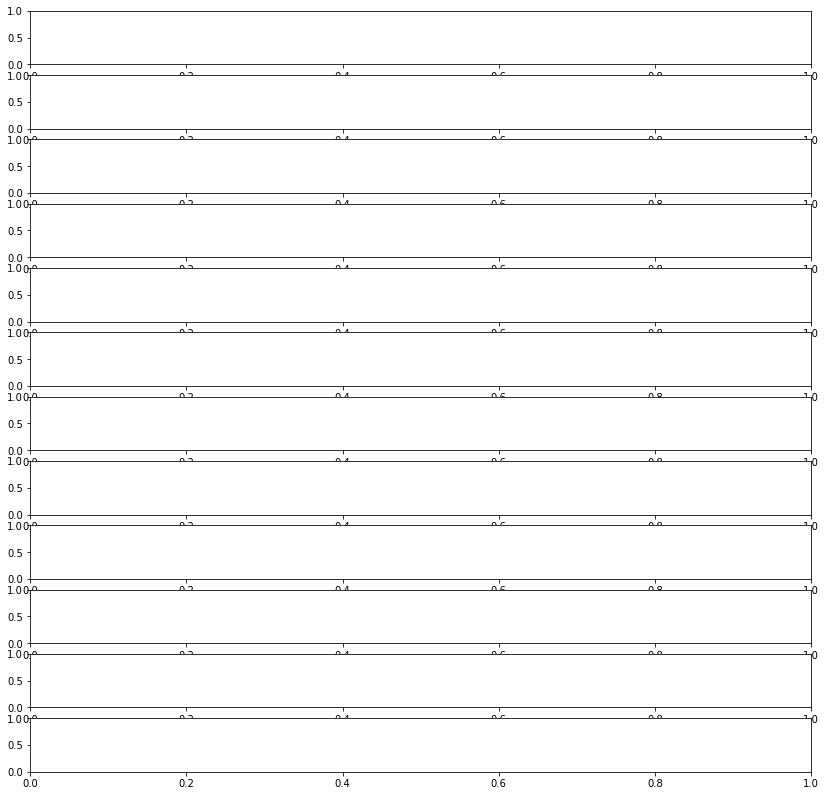

In [15]:
dataset = 'ZhejiangDatabase'
N = 2048
L = 12
stride = 128
thr_dice = 0.8
ptg_voting = 0.5
out_folder = '/home/guille/Escritorio/Ruben/{}/{}'.format(dataset,mname)

if not os.path.isdir(out_folder):
    pathlib.Path(out_folder).mkdir(parents=True, exist_ok=True)

f,ax = plt.subplots(nrows=12, figsize=(14,14))

Ponsets  = {}
Poffsets = {}
QRSonsets  = {}
QRSoffsets = {}
Tonsets  = {}
Toffsets = {}

for file in tqdm.tqdm(glob.glob(os.path.join(basedir,'ZhejiangDatabase','PVCVTECGData','*.csv'))):
    signal = pd.read_csv(file)
    root,fname = os.path.split(file)
    fname, ext = os.path.splitext(fname)
    
    # Downsample signal
    down_factor = int(fs//250)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(moving_operation(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)
#     ampl = np.median(moving_operation(signal,200,sak.signal.abs_max),axis=0)

    signal = np.pad(signal,((512,0),(0,0)),mode='edge')
    if signal.shape[0] < N:
        signal = np.pad(signal,((0,N-signal.shape[0]),(0,0)),mode='edge')

    # Correct amplitudes
    signal = signal/ampl

    # Obtain segmentation
    if isinstance(model, list):
        for i,m in enumerate(model):
            if i == 0:
                segmentation = predict_mask(signal, N, stride, m, ptg_voting).astype(int)
            else:
                segmentation += predict_mask(signal, N, stride, m, ptg_voting)
                
        segmentation = segmentation >= 3
    else:
        segmentation = predict_mask(signal, N, stride, model, ptg_voting)
    
    # Morphological operations
    qrs               = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
    segmentation[1,:] = cv2.morphologyEx(qrs,                                 cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        
    # Obtain onsets/offsets
    pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
    qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
    ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])
    
    # Save stuff
    Ponsets[fname] = ((np.array(pon)-512)*down_factor).tolist()
    Poffsets[fname] = ((np.array(poff)-512)*down_factor).tolist()
    QRSonsets[fname] = ((np.array(qrson)-512)*down_factor).tolist()
    QRSoffsets[fname] = ((np.array(qrsoff)-512)*down_factor).tolist()
    Tonsets[fname] = ((np.array(ton)-512)*down_factor).tolist()
    Toffsets[fname] = ((np.array(toff)-512)*down_factor).tolist()
    
    # Plot
    [ax[i].plot(signal[:,i]) for i in range(L)]
    [ax[i].set_xlim([0,signal.shape[0]]) for i in range(L)]
    [[ax[i].axvspan(pon[j],poff[j], linewidth=0, alpha=0.15, color='red') for j,_ in enumerate(pon)] for i in range(L)]
    [[ax[i].axvspan(qrson[j],qrsoff[j], linewidth=0, alpha=0.15, color='green') for j,_ in enumerate(qrson)] for i in range(L)]
    [[ax[i].axvspan(ton[j],toff[j], linewidth=0, alpha=0.15, color='magenta') for j,_ in enumerate(ton)] for i in range(L)]
    f.tight_layout()
    f.subplots_adjust(hspace=0.00,wspace=0.05)
    f.savefig(os.path.join(out_folder,'{}_{}.png'.format(mname,fname)))
    [ax[i].clear() for i in range(L)]

sak.save_data(  Ponsets,  os.path.join(out_folder,  'Ponsets.csv'))
sak.save_data(  Poffsets, os.path.join(out_folder,  'Poffsets.csv'))
sak.save_data(QRSonsets,  os.path.join(out_folder,'QRSonsets.csv'))
sak.save_data(QRSoffsets, os.path.join(out_folder,'QRSoffsets.csv'))
sak.save_data(  Tonsets,  os.path.join(out_folder,  'Tonsets.csv'))
sak.save_data(  Toffsets, os.path.join(out_folder,  'Toffsets.csv'))


# Testing set (generated)

100%|██████████| 43/43 [01:02<00:00,  1.44s/it]


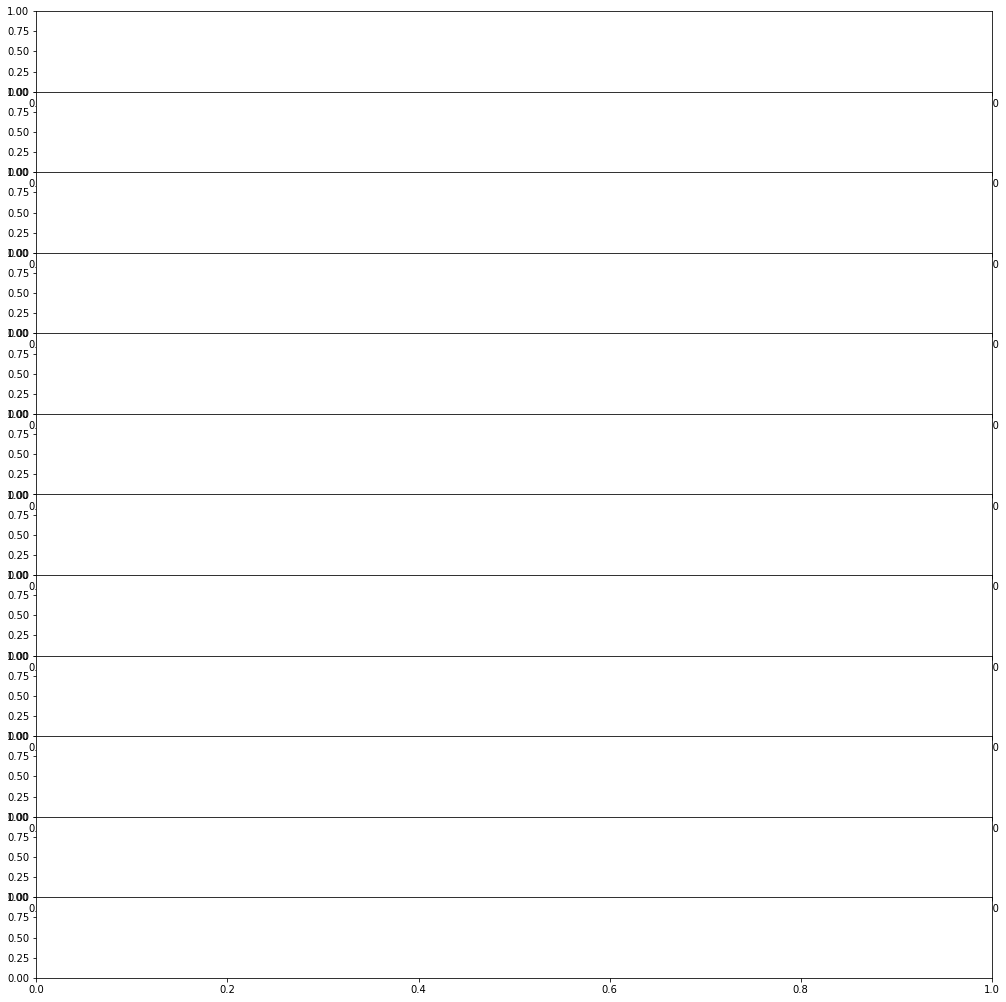

In [17]:
dataset = 'Test'
N = 2048
L = 12
stride = 128
thr_dice = 0.8
ptg_voting = 0.5
fs = 1000
out_folder = '/home/guille/Escritorio/Ruben/{}/{}'.format(dataset,mname)

if not os.path.isdir(out_folder):
    pathlib.Path(out_folder).mkdir(parents=True, exist_ok=True)

f,ax = plt.subplots(nrows=12, figsize=(14,14))

Ponsets  = {}
Poffsets = {}
QRSonsets  = {}
QRSoffsets = {}
Tonsets  = {}
Toffsets = {}

signals = sp.io.loadmat('/home/guille/DADES/DADES/RubenDoste/{}/ECG_signal_Test.mat'.format(dataset))['ECG_signal_all']
signals = signals.swapaxes(0,2)
signals = signals.swapaxes(1,2)

for fname,signal in enumerate(tqdm.tqdm(signals)):
    # Downsample signal
    down_factor = int(fs//250)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(moving_operation(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)
#     ampl = np.median(moving_operation(signal,200,sak.signal.abs_max),axis=0)

    signal = np.pad(signal,((512,0),(0,0)),mode='edge')
    if signal.shape[0] < N:
        signal = np.pad(signal,((0,N-signal.shape[0]),(0,0)),mode='edge')

    # Correct amplitudes
    signal = signal/ampl

    # Obtain segmentation
    if isinstance(model, list):
        for i,m in enumerate(model):
            if i == 0:
                segmentation = predict_mask(signal, N, stride, m, ptg_voting).astype(int)
            else:
                segmentation += predict_mask(signal, N, stride, m, ptg_voting)
                
        segmentation = segmentation >= 3
    else:
        segmentation = predict_mask(signal, N, stride, model, ptg_voting)
    
    # Morphological operations
    qrs               = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
    segmentation[1,:] = cv2.morphologyEx(qrs,                                 cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        
    # Obtain onsets/offsets
    pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
    qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
    ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])
    
    # Save stuff
    Ponsets[fname] = ((np.array(pon)-512)*down_factor).tolist()
    Poffsets[fname] = ((np.array(poff)-512)*down_factor).tolist()
    QRSonsets[fname] = ((np.array(qrson)-512)*down_factor).tolist()
    QRSoffsets[fname] = ((np.array(qrsoff)-512)*down_factor).tolist()
    Tonsets[fname] = ((np.array(ton)-512)*down_factor).tolist()
    Toffsets[fname] = ((np.array(toff)-512)*down_factor).tolist()
    
    # Plot
    [ax[i].plot(signal[:,i]) for i in range(L)]
    [ax[i].set_xlim([0,signal.shape[0]]) for i in range(L)]
    [[ax[i].axvspan(pon[j],poff[j], linewidth=0, alpha=0.15, color='red') for j,_ in enumerate(pon)] for i in range(L)]
    [[ax[i].axvspan(qrson[j],qrsoff[j], linewidth=0, alpha=0.15, color='green') for j,_ in enumerate(qrson)] for i in range(L)]
    [[ax[i].axvspan(ton[j],toff[j], linewidth=0, alpha=0.15, color='magenta') for j,_ in enumerate(ton)] for i in range(L)]
    f.tight_layout()
    f.subplots_adjust(hspace=0.00,wspace=0.05)
    f.savefig(os.path.join(out_folder,'{}_{}.png'.format(mname,fname)))
    [ax[i].clear() for i in range(L)]

sak.save_data(  Ponsets,  os.path.join(out_folder,  'Ponsets.csv'))
sak.save_data(  Poffsets, os.path.join(out_folder,  'Poffsets.csv'))
sak.save_data(QRSonsets,  os.path.join(out_folder,'QRSonsets.csv'))
sak.save_data(QRSoffsets, os.path.join(out_folder,'QRSoffsets.csv'))
sak.save_data(  Tonsets,  os.path.join(out_folder,  'Tonsets.csv'))
sak.save_data(  Toffsets, os.path.join(out_folder,  'Toffsets.csv'))


# Training set (generated)

100%|██████████| 143/143 [32:55<00:00, 13.82s/it]


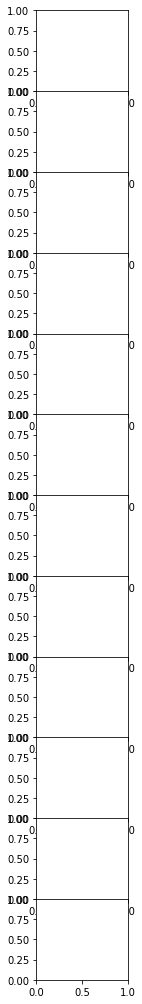

In [61]:
dataset = 'Training'
N = 2048
L = 12
stride = 128
thr_dice = 0.8
ptg_voting = 0.5
fs = 1000
out_folder = '/home/guille/Escritorio/Ruben/{}/{}'.format(dataset,mname)

if not os.path.isdir(out_folder):
    pathlib.Path(out_folder).mkdir(parents=True, exist_ok=True)

f,ax = plt.subplots(nrows=12, figsize=(2,14))

QRSonsets  = {}
QRSoffsets = {}

for fname in tqdm.tqdm(glob.glob('/home/guille/DADES/DADES/RubenDoste/{}/Augmented_not_normalized/*.mat'.format(dataset))):
    signals = sp.io.loadmat(fname)['ECG_signal']
    signals = signals.swapaxes(0,2)
    signals = signals.swapaxes(1,2)
    
    fname = os.path.splitext(os.path.split(fname)[1])[0]

    for index,signal in enumerate(signals):
        # Downsample signal
        down_factor = int(fs//250)
        signal = sp.signal.decimate(signal,down_factor,axis=0)
        
        original_size = signal.shape[0]

        # Compute moving operation for matching amplitude criteria to development set
        ampl = np.median(moving_operation(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)
    #     ampl = np.median(moving_operation(signal,200,sak.signal.abs_max),axis=0)

        signal = np.pad(signal,((512,0),(0,0)),mode='edge')
        if signal.shape[0] < N:
            signal = np.pad(signal,((0,N-signal.shape[0]),(0,0)),mode='edge')

        # Correct amplitudes
        signal = signal/ampl

        # Obtain segmentation
        if isinstance(model, list):
            for i,m in enumerate(model):
                if i == 0:
                    segmentation = predict_mask(signal, N, stride, m, ptg_voting).astype(int)
                else:
                    segmentation += predict_mask(signal, N, stride, m, ptg_voting)

            segmentation = segmentation >= 3
        else:
            segmentation = predict_mask(signal, N, stride, model, ptg_voting)

        # Morphological operations
        qrs               = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        segmentation[1,:] = cv2.morphologyEx(qrs,                                 cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)

        # Obtain onsets/offsets
        qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])

        # Save stuff
        QRSonsets[fname+"_"+str(index)] = ((np.array(qrson)-512)*down_factor).tolist()
        QRSoffsets[fname+"_"+str(index)] = ((np.array(qrsoff)-512)*down_factor).tolist()

        # Plot
        [ax[i].plot(signal[:,i]) for i in range(L)]
        [ax[i].set_xlim([512,512+original_size]) for i in range(L)]
        [[ax[i].axvspan(qrson[j],qrsoff[j], linewidth=0, alpha=0.15, color='green') for j,_ in enumerate(qrson)] for i in range(L)]
        f.tight_layout()
        f.subplots_adjust(hspace=0.00,wspace=0.05)
        f.savefig(os.path.join(out_folder,'{}_{}.png'.format(fname,index)))
        [ax[i].clear() for i in range(L)]

sak.save_data(QRSonsets,  os.path.join(out_folder,'QRSonsets.csv'))
sak.save_data(QRSoffsets, os.path.join(out_folder,'QRSoffsets.csv'))


In [75]:
dataset = 'ZhejiangDatabase'
out_folder = '/home/guille/Escritorio/Ruben/{}/{}'.format(dataset,mname)

Ponsets = sak.load_data(os.path.join(out_folder,'Ponsets.csv'))
Poffsets = sak.load_data(os.path.join(out_folder,'Poffsets.csv'))
QRSonsets = sak.load_data(os.path.join(out_folder,'QRSonsets.csv'))
QRSoffsets = sak.load_data(os.path.join(out_folder,'QRSoffsets.csv'))
Tonsets = sak.load_data(os.path.join(out_folder,'Tonsets.csv'))
Toffsets = sak.load_data(os.path.join(out_folder,'Toffsets.csv'))

for wave in ['P', 'QRS', 'T']:
    onsets = eval("{}onsets".format(wave))
    offsets = eval("{}offsets".format(wave))
    
    for k in onsets:
        mark_delete = []
        
        for i,(on,off) in enumerate(zip(onsets[k], offsets[k])):
            if (on < 0) and (off <= 0):
                mark_delete.append(i)
            elif (on < 0):
                onsets[k][i] = 0
        
        onsets[k]  = np.delete(onsets[k],mark_delete)
        offsets[k] = np.delete(offsets[k],mark_delete)
        
sak.save_data(Ponsets,    os.path.join(out_folder,   'Ponsets.csv'))
sak.save_data(Poffsets,   os.path.join(out_folder,  'Poffsets.csv'))
sak.save_data(QRSonsets,  os.path.join(out_folder, 'QRSonsets.csv'))
sak.save_data(QRSoffsets, os.path.join(out_folder,'QRSoffsets.csv'))
sak.save_data(Tonsets,    os.path.join(out_folder,   'Tonsets.csv'))
sak.save_data(Toffsets,   os.path.join(out_folder,  'Toffsets.csv'))


In [74]:
np.delete(onsets[k],mark_delete)

array([1048, 2472, 5416, 6832, 8296])

In [67]:
QRSonsets

{'ECG_CGQ_0_0': array([16]),
 'ECG_CGQ_0_1': array([24]),
 'ECG_CGQ_0_2': array([12]),
 'ECG_CGQ_0_3': array([16]),
 'ECG_CGQ_0_4': array([24]),
 'ECG_CGQ_0_5': array([44]),
 'ECG_CGQ_0_6': array([12]),
 'ECG_CGQ_0_7': array([8]),
 'ECG_CGQ_0_8': array([12]),
 'ECG_CGQ_0_9': array([8]),
 'ECG_CGQ_0_10': array([8]),
 'ECG_CGQ_0_11': array([16]),
 'ECG_CGQ_1_0': array([16]),
 'ECG_CGQ_1_1': array([24]),
 'ECG_CGQ_1_2': array([8]),
 'ECG_CGQ_1_3': array([16]),
 'ECG_CGQ_1_4': array([24]),
 'ECG_CGQ_1_5': array([44]),
 'ECG_CGQ_1_6': array([8]),
 'ECG_CGQ_1_7': array([8]),
 'ECG_CGQ_1_8': array([12]),
 'ECG_CGQ_1_9': array([8]),
 'ECG_CGQ_1_10': array([8]),
 'ECG_CGQ_1_11': array([16]),
 'ECG_CGQ_10_0': array([16]),
 'ECG_CGQ_10_1': array([20]),
 'ECG_CGQ_10_2': array([8]),
 'ECG_CGQ_10_3': array([16]),
 'ECG_CGQ_10_4': array([24]),
 'ECG_CGQ_10_5': array([44]),
 'ECG_CGQ_10_6': array([12]),
 'ECG_CGQ_10_7': array([8]),
 'ECG_CGQ_10_8': array([12]),
 'ECG_CGQ_10_9': array([8]),
 'ECG_CGQ_1

(16006, 12)
/home/guille/DADES/DADES/RubenDoste/ZhejiangDatabase/PVCVTECGData/875558.csv


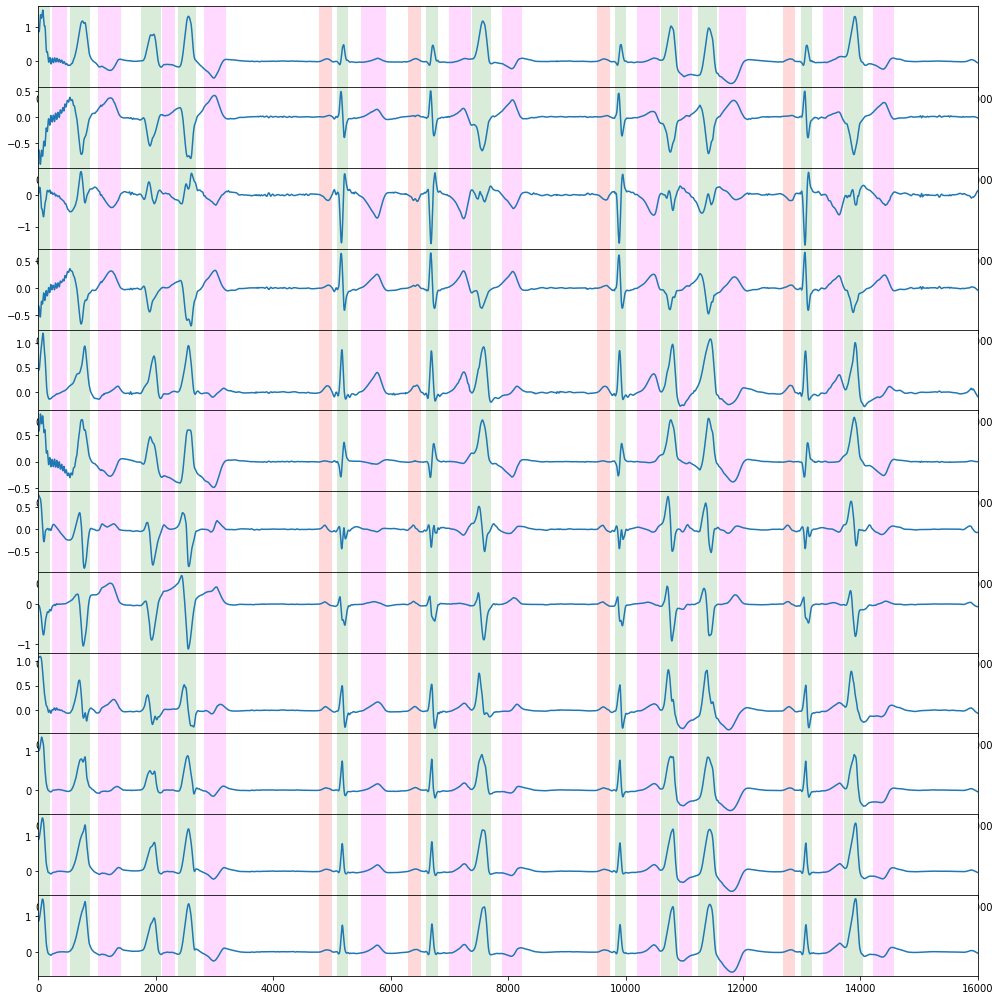

In [77]:
Ponsets = sak.load_data(os.path.join(out_folder,'Ponsets.csv'))
Poffsets = sak.load_data(os.path.join(out_folder,'Poffsets.csv'))
QRSonsets = sak.load_data(os.path.join(out_folder,'QRSonsets.csv'))
QRSoffsets = sak.load_data(os.path.join(out_folder,'QRSoffsets.csv'))
Tonsets = sak.load_data(os.path.join(out_folder,'Tonsets.csv'))
Toffsets = sak.load_data(os.path.join(out_folder,'Toffsets.csv'))

listfiles = glob.glob(os.path.join(basedir,'ZhejiangDatabase','PVCVTECGData','*.csv'))

file = listfiles[np.random.randint(len(listfiles))]
# file = os.path.join(basedir,'1000364.csv')
root,fname = os.path.split(file)
fname, ext = os.path.splitext(fname)


# signal = pd.read_csv(os.path.join(basedir,'970213.csv'))
# signal = pd.read_csv('/media/guille/DADES/DADES/RubenDoste/PVCVTECGData/1009731.csv')
# signal = pd.read_csv('/media/guille/DADES/DADES/RubenDoste/PVCVTECGData/970213.csv')
# signal = pd.read_csv('/media/guille/DADES/DADES/RubenDoste/PVCVTECGData/1003549.csv').T
signal = pd.read_csv(file).values

print(signal.shape)

print(file)

N = 2048
stride = 128
thr_dice = 0.8
ptg_voting = 0.5

# Compute moving operation for matching amplitude criteria to development set
ampl = np.median(moving_operation(signal,1536,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

# Correct amplitudes
signal = signal/ampl

# Obtain segmentation
pon,poff     = Ponsets[fname],Poffsets[fname]
qrson,qrsoff = QRSonsets[fname],QRSoffsets[fname]
ton,toff     = Tonsets[fname],Toffsets[fname]

L = signal.shape[1]
f,ax=plt.subplots(nrows=L,figsize=(14,14))
[ax[i].plot(signal[:,i]) for i in range(L)]
[ax[i].set_xlim([0,signal.shape[0]]) for i in range(L)]
[[ax[i].axvspan(pon[j],poff[j], linewidth=0, alpha=0.15, color='red') for j,_ in enumerate(pon)] for i in range(L)]
[[ax[i].axvspan(qrson[j],qrsoff[j], linewidth=0, alpha=0.15, color='green') for j,_ in enumerate(qrson)] for i in range(L)]
[[ax[i].axvspan(ton[j],toff[j], linewidth=0, alpha=0.15, color='magenta') for j,_ in enumerate(ton)] for i in range(L)]
f.tight_layout()
f.subplots_adjust(hspace=0.00,wspace=0.05)
plt.show()

(19725, 12)

TypeError: '(slice(None, 2048, None), 4)' is an invalid key

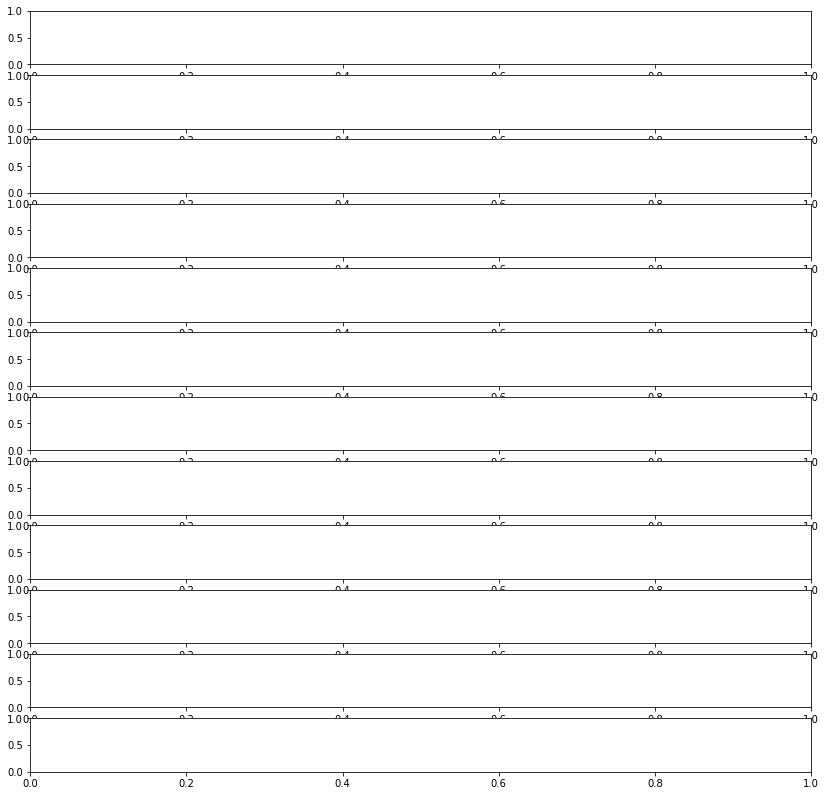

In [41]:
f,ax=plt.subplots(nrows=L,figsize=(14,14))
ax[i].plot(signal[:2048,i])